                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:               673931
Model:                            GLM   Df Residuals:                   673926
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27334.
Date:                Sat, 18 Jan 2025   Deviance:                       54668.
Time:                        23:46:12   Pearson chi2:                 6.88e+05
No. Iterations:                    10   Pseudo R-squ. (CS):            0.01060
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   3.15e-06     49.155      0.0

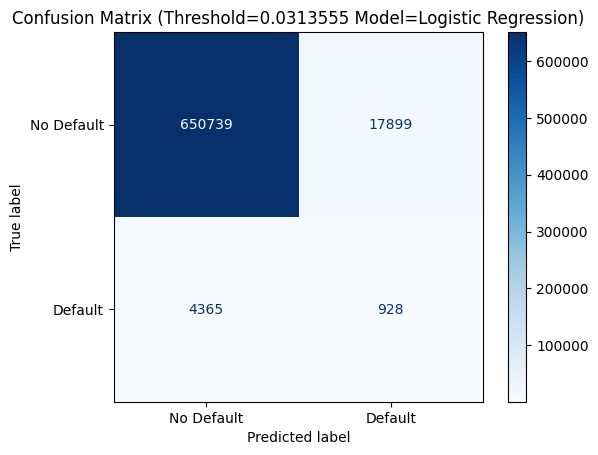

Model: Logistic Regression
Threshold: 0.0313555
Precision: 0.05, Recall: 0.18, F1-Score: 0.08

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:              1337276
Model:                            GLM   Df Residuals:                  1337271
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.0777e+05
Date:                Sat, 18 Jan 2025   Deviance:                   1.4155e+06
Time:                        23:46:15   Pearson chi2:                 1.34e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2795
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

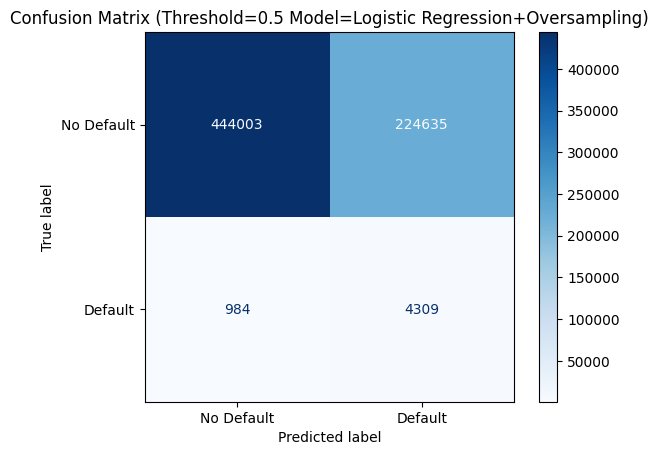

Model: Logistic Regression+Oversampling
Threshold: 0.5
Precision: 0.02, Recall: 0.81, F1-Score: 0.04



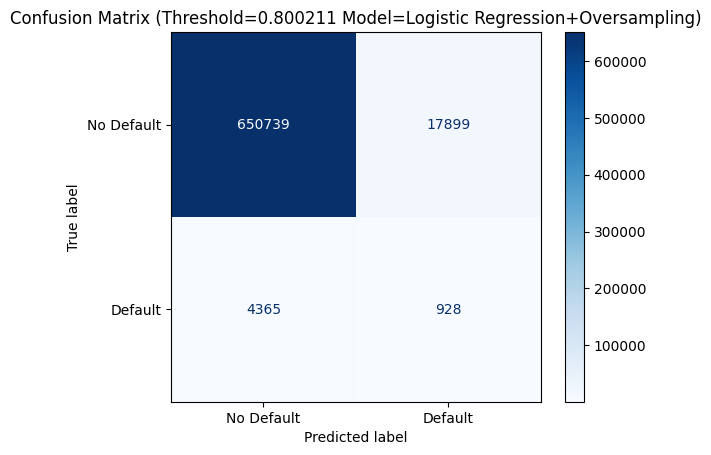

Model: Logistic Regression+Oversampling
Threshold: 0.800211
Precision: 0.05, Recall: 0.18, F1-Score: 0.08

[LightGBM] [Info] Number of positive: 3705, number of negative: 468046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 471751, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007854 -> initscore=-4.838883
[LightGBM] [Info] Start training from score -4.838883
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

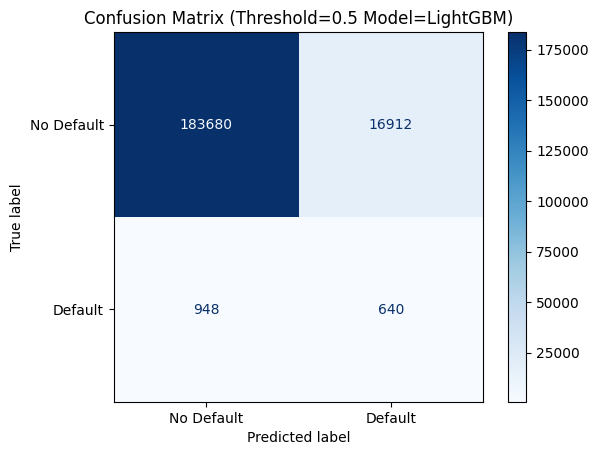

Model: LightGBM
Threshold: 0.5
Precision: 0.04, Recall: 0.40, F1-Score: 0.07



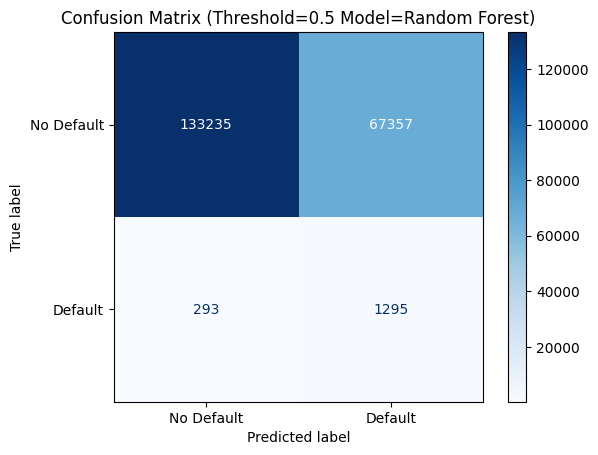

Model: Random Forest
Threshold: 0.5
Precision: 0.02, Recall: 0.82, F1-Score: 0.04



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

def load_data():
    url = "https://raw.githubusercontent.com/jh85/glm/refs/heads/main/default_risk.csv.gz"
    df = pd.read_csv(url, compression="gzip")
    return df

def evaluate_model(y_true, predictions, threshold, model_desc):
    """
    Evaluate model performance at a specific threshold.
    """
    # Convert probabilities to binary classes
    predicted_classes = (predictions >= threshold).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Threshold={threshold} Model={model_desc})")
    plt.show()

    # Calculate precision, recall, and F1-score
    precision, recall, f1, support = precision_recall_fscore_support(y_true, predicted_classes, average="binary")
    print(f"Model: {model_desc}")
    print(f"Threshold: {threshold}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}\n")

def logistic_regression_on_imbalanced_data():
    df = load_data()
    y = df["Default"]
    X = df[["RiskLevel", "YOB", "Year", "DJX_Return", "GDP"]]

    # Build Logistic model and fit
    X = sm.add_constant(X)
    model = sm.GLM(y,X,family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())
    predictions = result.predict(exog=X)

    # Evaluate at the best threshold
    threshold = 0.0313555
    evaluate_model(y, predictions, threshold, "Logistic Regression")

def logistic_regression_on_balanced_data():
    df = load_data()
    y = df["Default"]
    X = df[["RiskLevel", "YOB", "Year", "DJX_Return", "GDP"]]

    # Oversampling with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Build Logistic model and fit on balanced dataset
    X_resampled = sm.add_constant(X_resampled)
    model = sm.GLM(y_resampled, X_resampled, family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())

    # Evaluate on the original data
    X = sm.add_constant(X)
    predictions = result.predict(exog=X)
    threshold = 0.5
    evaluate_model(y, predictions, threshold, "Logistic Regression+Oversampling")

    # Evaluate at the best threshold
    threshold = 0.800211
    evaluate_model(y, predictions, threshold, "Logistic Regression+Oversampling")

def lightgbm_classification():
    df = load_data()
    y = df["Default"]
    X = df[["RiskLevel", "YOB", "Year", "DJX_Return", "GDP"]]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Calculate scale_pos_weight for handling imbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # Train LightGBM model
    trn_data = lgb.Dataset(X_train, label=y_train)
    tst_data  = lgb.Dataset(X_test, label=y_test, reference=trn_data)
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'scale_pos_weight': scale_pos_weight,  # Handle imbalance
        'seed': 42
    }
    model = lgb.train(params, trn_data, valid_sets=[trn_data, tst_data], num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])
    # Predict probabilities on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Evaluate model
    evaluate_model(y_test, y_pred, 0.5, "LightGBM")

def randomforest_classification():
    df = load_data()
    y = df["Default"]
    X = df[["RiskLevel", "YOB", "Year", "DJX_Return", "GDP"]]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate model
    evaluate_model(y_test, y_pred, 0.5, "Random Forest")

def main():
    logistic_regression_on_imbalanced_data()
    logistic_regression_on_balanced_data()
    lightgbm_classification()
    randomforest_classification()   

main()